In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA  # For latent space visualization (optional)

# Load MNIST dataset from Keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize images to [0, 1] and flatten them (28x28 -> 784)
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)


In [28]:
latent_dim = 2  # We use 2 dimensions for easy visualization. For production, you could use a higher dimension (e.g., 128).

encoder_inputs = keras.Input(shape=(28 * 28,), name="encoder_input")
x = layers.Dense(512, activation="relu")(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
# Output layers for the mean and log variance of the latent distribution
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)


In [29]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Use a Lambda layer to wrap the sampling function.
z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])


In [30]:
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(512, activation="relu")(x)
decoder_outputs = layers.Dense(28 * 28, activation="sigmoid")(x)

# Build the decoder model.
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [31]:
# Get reconstructed output from the decoder
reconstructed = decoder(z)

# Define the full VAE model mapping input -> reconstruction.
vae = keras.Model(encoder_inputs, reconstructed, name="vae_mlp")


In [32]:
# Reconstruction loss: binary crossentropy (scaled by the input dimension)
reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, reconstructed)
reconstruction_loss *= 28 * 28  # Scale to match original image size

# KL divergence loss: measure how much q(z|x) diverges from the prior p(z) ~ N(0, I)
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss, axis=-1)
kl_loss *= -0.5

# Total loss: ELBO loss is the sum of the reconstruction loss and KL divergence
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")
vae.summary()


Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 512)          401920      ['encoder_input[0][0]']          
                                                                                                  
 dense_16 (Dense)               (None, 256)          131328      ['dense_15[0][0]']               
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['dense_16[0][0]']               
                                                                                            

In [33]:
# Train the model; note that the target is the input itself.
history = vae.fit(x_train, x_train,
                  epochs=30,
                  batch_size=128,
                  validation_data=(x_test, x_test))


Epoch 1/30
469/469 [==============================] - 12s 20ms/step - loss: 182.9315 - val_loss: 161.9349
Epoch 2/30
469/469 [==============================] - 8s 18ms/step - loss: 157.8015 - val_loss: 154.6396
Epoch 3/30
469/469 [==============================] - 9s 19ms/step - loss: 152.8467 - val_loss: 151.3380
Epoch 4/30
469/469 [==============================] - 12s 25ms/step - loss: 149.8032 - val_loss: 148.9754
Epoch 5/30
469/469 [==============================] - 10s 22ms/step - loss: 147.5548 - val_loss: 147.3105
Epoch 6/30
469/469 [==============================] - 10s 20ms/step - loss: 145.9319 - val_loss: 145.3621
Epoch 7/30
469/469 [==============================] - 11s 23ms/step - loss: 144.5628 - val_loss: 144.4090
Epoch 8/30
469/469 [==============================] - 11s 23ms/step - loss: 143.4746 - val_loss: 143.5008
Epoch 9/30
469/469 [==============================] - 11s 23ms/step - loss: 142.4578 - val_loss: 142.5942
Epoch 10/30
469/469 [===========================

313/313 [==============================] - 2s 5ms/step


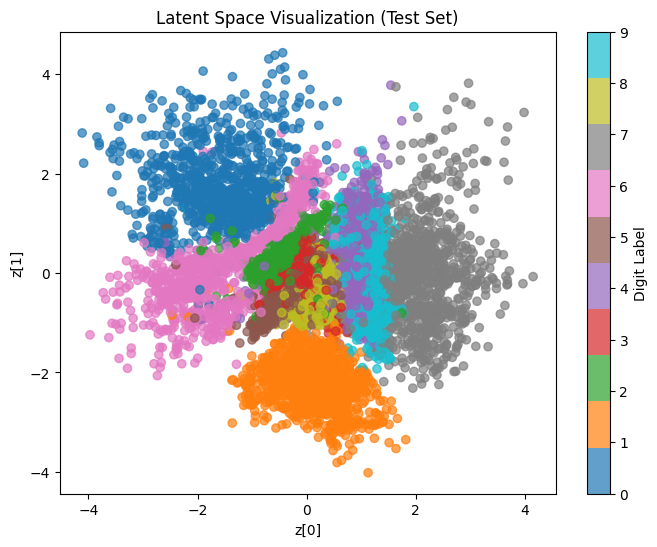

In [34]:
# Build an encoder model to output the latent mean (z_mean)
encoder = keras.Model(encoder_inputs, z_mean, name="encoder")

# Encode the test set into the latent space
z_test = encoder.predict(x_test)


# Plot with colors corresponding to digit labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, cmap="tab10", alpha=0.7)

# Add color bar to indicate which color corresponds to which digit
plt.colorbar(scatter, label="Digit Label")

plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Visualization (Test Set)")

plt.show()

Reconstructing a bunch of random test images

1/1 [==============================] - 0s 481ms/step


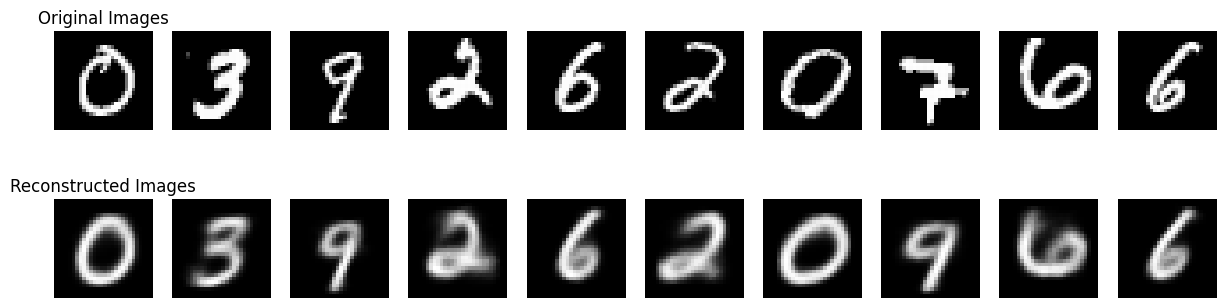

In [35]:
n = 10  # Number of digits to display

# Select random images from the test set
random_test_images = x_test[np.random.choice(len(x_test), n)]

# Get the reconstructed images
reconstructed_images = vae.predict(random_test_images)

# Plot the original and reconstructed images
fig, axes = plt.subplots(2, n, figsize=(15, 4))
for i in range(n):
    axes[0, i].imshow(random_test_images[i].reshape(28, 28), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap="gray")
    axes[1, i].axis("off")
axes[0, 0].set_title("Original Images")
axes[1, 0].set_title("Reconstructed Images")
plt.show()


Some of the above are not very good, so we retrain with higher dimensional latent representations, and use TSNE to visualise latent space at lower dimensions. 

Model: "vae24_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_37 (Dense)               (None, 512)          401920      ['encoder_input[0][0]']          
                                                                                                  
 dropout (Dropout)              (None, 512)          0           ['dense_37[0][0]']               
                                                                                                  
 dense_38 (Dense)               (None, 256)          131328      ['dropout[0][0]']                
                                                                                          

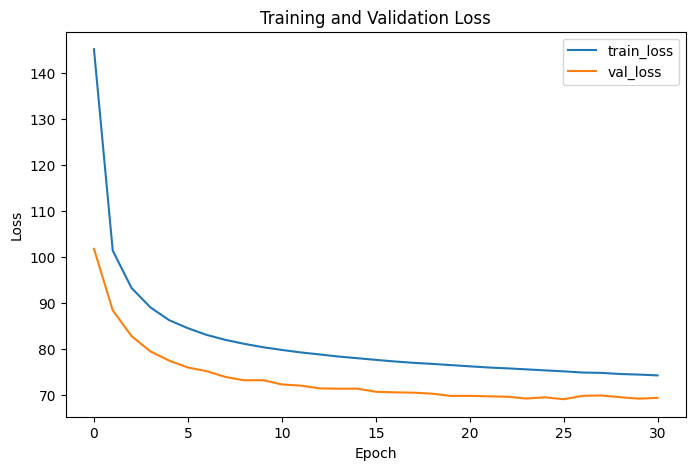

313/313 [==============================] - 2s 6ms/step


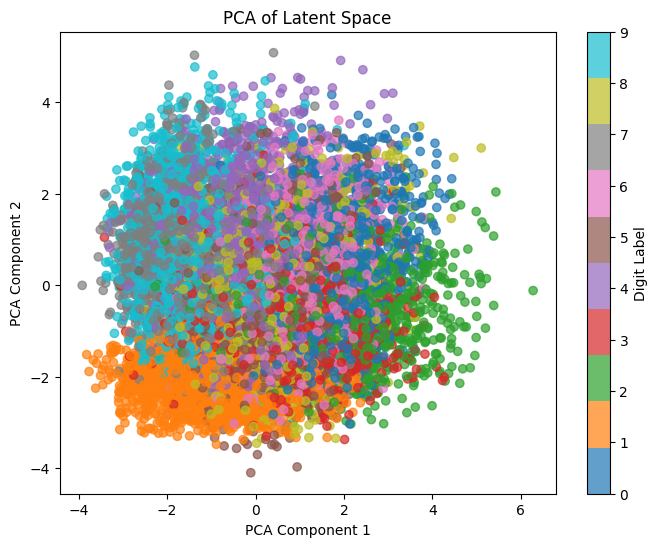

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

adam = Adam(learning_rate=1e-3)  # Or any other learning rate

# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,          
#     restore_best_weights=True
# )




latent_dim = 24  # We use 2 dimensions for easy visualization. For production, you could use a higher dimension (e.g., 128).

encoder_inputs = keras.Input(shape=(28 * 28,), name="encoder_input")
x = layers.Dense(512, activation="relu")(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
# Output layers for the mean and log variance of the latent distribution
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)


z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(512, activation="relu")(x)
decoder_outputs = layers.Dense(28 * 28, activation="sigmoid")(x)

# Build the decoder model.
decoder24 = keras.Model(latent_inputs, decoder_outputs, name="decoder24")

# Get reconstructed output from the decoder
reconstructed24 = decoder24(z)

# Define the full vae24 model mapping input -> reconstruction.
vae24 = keras.Model(encoder_inputs, reconstructed24, name="vae24_mlp")


# Reconstruction loss: binary crossentropy (scaled by the input dimension)
reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, reconstructed24)
reconstruction_loss *= 28 * 28  # Scale to match original image size

# KL divergence loss: measure how much q(z|x) diverges from the prior p(z) ~ N(0, I)
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss, axis=-1)
kl_loss *= -0.5

# Total loss: ELBO loss is the sum of the reconstruction loss and KL divergence
vae24_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae24.add_loss(vae24_loss)
vae24.compile(optimizer="adam")
vae24.summary()


# Train the model; note that the target is the input itself.
history = vae24.fit(x_train, x_train,
                  epochs=50,
                  batch_size=128,
                  validation_data=(x_test, x_test))

#PLot the loss curves below


# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Build an encoder model to output the latent mean (z_mean)



encoder24 = keras.Model(encoder_inputs, z_mean, name="encoder24")

# Encode the test set into the latent space
z_test = encoder24.predict(x_test)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Reduce higher-dimensional latent space to 2D using PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_test)

# Scatter plot of PCA-reduced latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Digit Label")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Latent Space")
plt.show()


Reconstructing images again with more expressive model, vae24.

1/1 [==============================] - 1s 1s/step


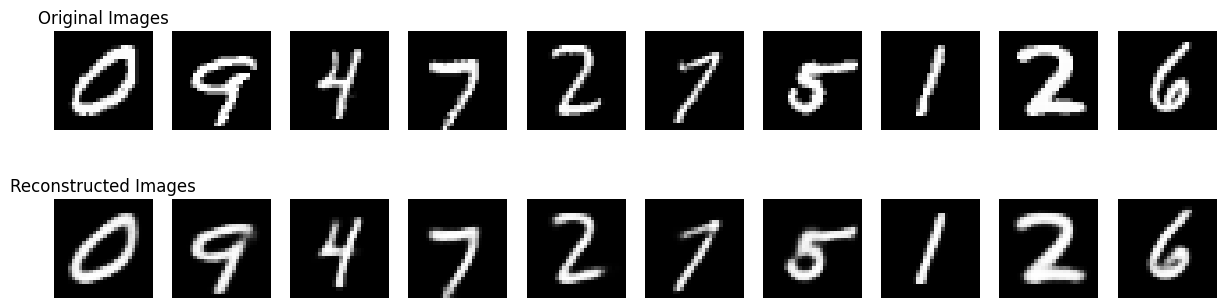

In [46]:
n = 10  # Number of digits to display

# Select random images from the test set
random_test_images = x_test[np.random.choice(len(x_test), n)]

# Get the reconstructed images
reconstructed_images = vae24.predict(random_test_images)

# Plot the original and reconstructed images
fig, axes = plt.subplots(2, n, figsize=(15, 4))
for i in range(n):
    axes[0, i].imshow(random_test_images[i].reshape(28, 28), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap="gray")
    axes[1, i].axis("off")
axes[0, 0].set_title("Original Images")
axes[1, 0].set_title("Reconstructed Images")
plt.show()


In [41]:
def plot_generated_images(decoder, n=15, digit_size=28, latent_dim=24):
    """
    Plots a grid of images generated from the decoder by varying the first two dimensions
    of the latent space and fixing the remaining dimensions to zero.
    
    Parameters:
        decoder (Model): The trained decoder model.
        n (int): Number of points per axis.
        digit_size (int): Height/width of the image (assumed square).
        latent_dim (int): Total dimensionality of the latent space (here 24).
    """
    # Create a grid of values for the first two dimensions
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # For each point in the grid, build a 24-dim latent vector
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # Initialize a latent vector with zeros
            z_sample = np.zeros((1, latent_dim))
            # Set the first two dimensions to the grid coordinates
            z_sample[0, 0] = xi
            z_sample[0, 1] = yi
            # Generate the image by decoding the latent vector
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            # Place the generated digit in the appropriate location in the figure grid
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap="Greys_r")
    plt.title("Generated MNIST Digits (Latent Dim = 24, Varying dims 1 & 2)")
    plt.axis("off")
    plt.show()

# Now call the function with your trained decoder (assumed to be named "decoder")
plot_generated_images(decoder, n=15, latent_dim=24)


ValueError: in user code:

    File "c:\stellenbosch university work and info\Work\PBMR\assignments\PROJECT\vae_env\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\stellenbosch university work and info\Work\PBMR\assignments\PROJECT\vae_env\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\stellenbosch university work and info\Work\PBMR\assignments\PROJECT\vae_env\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\stellenbosch university work and info\Work\PBMR\assignments\PROJECT\vae_env\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\stellenbosch university work and info\Work\PBMR\assignments\PROJECT\vae_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\stellenbosch university work and info\Work\PBMR\assignments\PROJECT\vae_env\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "decoder" is incompatible with the layer: expected shape=(None, 2), found shape=(None, 24)


Interpolating between 1 and 7... predict using those two digits, and plot the reconstruction of the latent space between them.

1/1 [==============================] - 0s 208ms/step


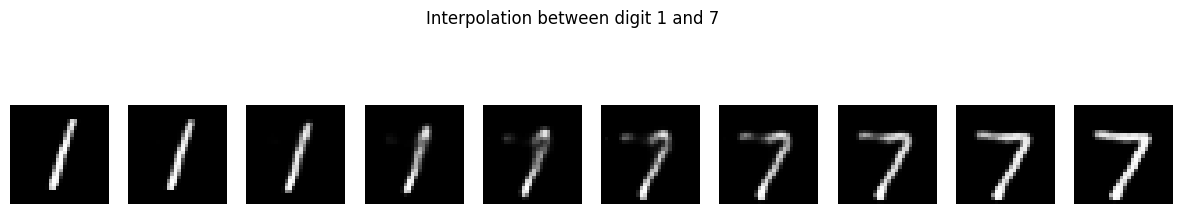

1/1 [==============================] - 0s 58ms/step


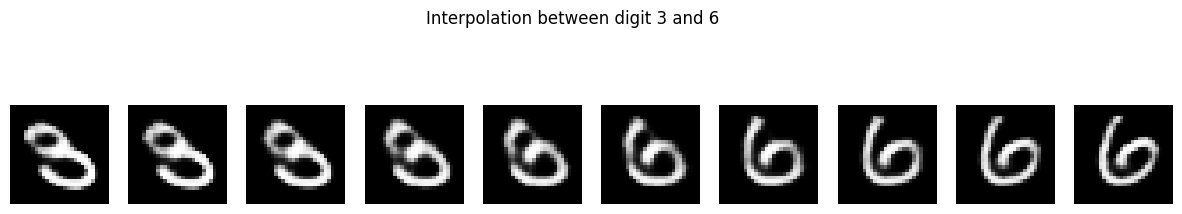

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Example 1: Interpolating between digit 1 and digit 7
digit_1 = 1  # Choose digit 1
digit_2 = 7  # Choose digit 7

# Get the latent representations for the first instance of each digit from the test set.
# (Assumes x_test, y_test, encoder, and decoder are defined.)
z1 = encoder24.predict(x_test[y_test == digit_1])[0]  
z2 = encoder24.predict(x_test[y_test == digit_2])[0]  

num_steps = 10  # Number of interpolation steps
interpolated_z = np.array([z1 * (1 - t) + z2 * t for t in np.linspace(0, 1, num_steps)])
interpolated_images = decoder24.predict(interpolated_z)

fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(interpolated_images[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
plt.suptitle("Interpolation between digit {} and {}".format(digit_1, digit_2))
plt.show()

# Example 2: Interpolating between digit 3 and digit 6
digit_3 = 3
digit_6 = 6

z1 = encoder24.predict(x_test[y_test == digit_3])[0]
z2 = encoder24.predict(x_test[y_test == digit_6])[0]

interpolated_z = np.array([z1 * (1 - t) + z2 * t for t in np.linspace(0, 1, num_steps)])
interpolated_images = decoder24.predict(interpolated_z)

fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(interpolated_images[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
plt.suptitle("Interpolation between digit {} and {}".format(digit_3, digit_6))
plt.show()


MNIST denoising with the vae24 model.

313/313 [==============================] - 3s 8ms/step


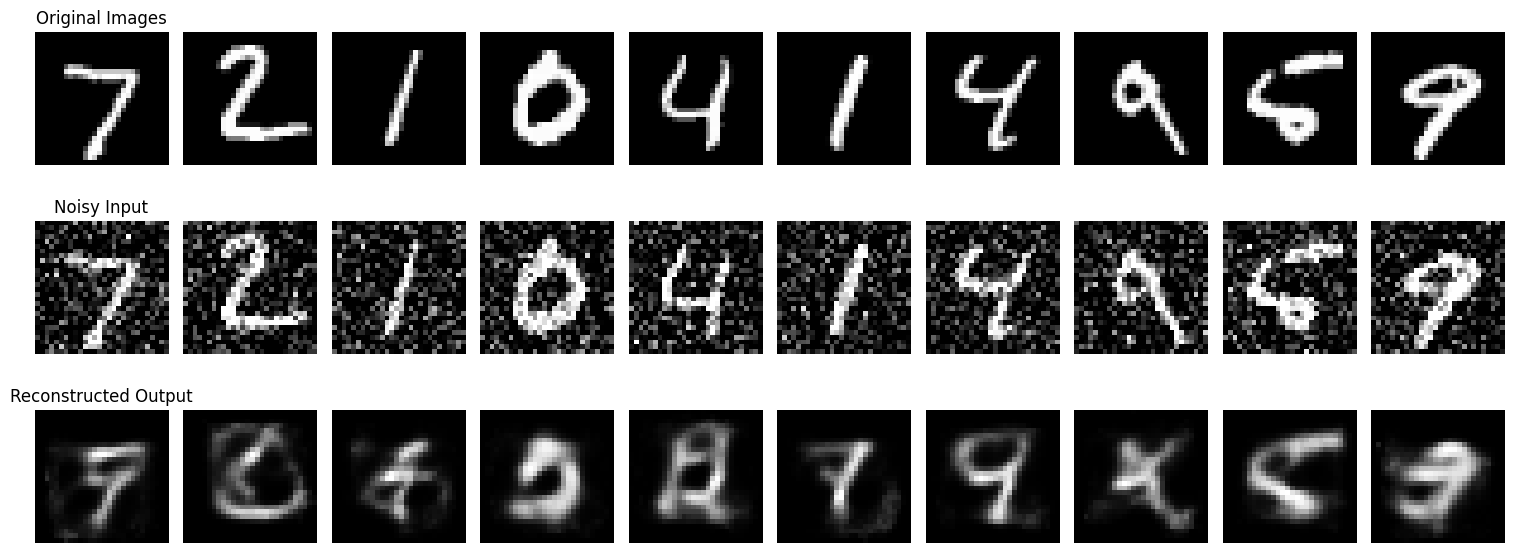

In [47]:
noise_factor = 0.3
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)  # Ensure the values remain in [0,1]

# Pass the noisy test images through the VAE (assumed to be the model "vae" built with latent_dim=24)
reconstructed_noisy = vae24.predict(x_test_noisy)

# Plot the original, noisy, and reconstructed images
n = 10  # Number of images to display
fig, axes = plt.subplots(3, n, figsize=(15, 6))
for i in range(n):
    axes[0, i].imshow(x_test[i].reshape(28, 28), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    axes[1, i].axis("off")
    axes[2, i].imshow(reconstructed_noisy[i].reshape(28, 28), cmap="gray")
    axes[2, i].axis("off")

axes[0, 0].set_title("Original Images")
axes[1, 0].set_title("Noisy Input")
axes[2, 0].set_title("Reconstructed Output")
plt.tight_layout()
plt.show()
